In [ ]:
from bs4 import BeautifulSoup
import requests
import warnings
import random
import string
import time

warnings.filterwarnings('ignore')

TIMEOUT = 5
CNET_BASE_URL = 'https://www.cnet.com'

def fetch_webpage(url, retry_count=5):
    html = None
    while not html and retry_count > 0:
        try:
            html = requests.get(url, verify=False, timeout=TIMEOUT).content
        except requests.exceptions.RequestException:
            print('Could not connect to {}. Retry count: {}'.format(url, retry_count))
            retry_count -= 1
    return html

def get_review_links(html):
    soup = BeautifulSoup(html, 'lxml')
    links = [(p.select('.itemInfo h3')[0].get_text(), 
              CNET_BASE_URL+p.select('a.imageWrap')[0]['href']) 
             for p in soup.select('section.product')]
    #links = [CNET_BASE_URL + a['href'] 
    #         for a in soup.select('section.product a.imageWrap')]
    return links

def get_review_page(html):
    soup = BeautifulSoup(html, 'lxml')
    [s.extract() for s in soup(['script', 'figure'])]
    text = soup.find_all(['p', 'ul'], attrs={'class': None})
    #text = soup.select('#editorReview > p, #editorReview > ul > li')
    text = None if len(text) == 0 else '\n\n'.join(['\n'.join(t.strings) for t in text])
    next_page = soup.select('a.nextPage')
    next_page = None if len(next_page) == 0 or next_page[0]['rel'][0] == 'prev' else CNET_BASE_URL + next_page[0]['href']
    return text, next_page

def get_full_review(first_page_url):
    full_review = ''
    review_title = BeautifulSoup(fetch_webpage(first_page_url))
    review_title = review_title.select('.headline')
    if len(review_title) > 0:
        review_title = review_title[0]
        review_title = review_title.get_text().strip()
    else:
        review_title = 'NO TITLE [{}]'.format(uuid())
    next_page = first_page_url
    while next_page:
        html = fetch_webpage(next_page)
        text, next_page = get_review_page(html)
        full_review += '\n\n' + (text if text else '')
    return full_review, review_title
        
def uuid():
    return ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

reviews = {}
html = fetch_webpage('https://www.cnet.com/topics/smart-home/products/')
links = get_review_links(html)
print('Page: 1')
for link in links:
    review, key = get_full_review(link[1])
    if key in reviews:
        key = key + ' ({})'.format(uuid())
    reviews[key] = (link, review)
    time.sleep(1)
"""    
for i in range(2, 158):
    print('Page:', i)
    html = fetch_webpage('https://www.cnet.com/topics/smart-home/products/{}/'.format(i))
    links = get_review_links(html)
    for link in links:
        review, key = get_full_review(link[1])
        if key in reviews:
            key = key + ' ({})'.format(uuid())
        reviews[key] = (link, review)
        time.sleep(1)
"""

In [ ]:
print(reviews)

In [ ]:
import pickle

with open('cnet-reviews.pickle', 'wb') as f:
    pickle.dump(reviews, f)

In [6]:
import pickle

with open('cnet-reviews.pickle', 'rb') as f:
    reviews = pickle.load(f)

In [ ]:
import csv

with open('cnet.csv', 'w') as f:
    writer = csv.writer(f, delimiter='|')
    for k,v in reviews.items():
        writer.writerow([v[0][0], v[0][1], k, v[1]])

In [ ]:
sample_reviews = {}
keys = list(reviews.keys())
for i in range(0, 628, 13):
    sample_reviews[keys[i]] = reviews[keys[i]]

# Analysis

In [2]:
import pandas as pd
import analyze_text as atxt
%matplotlib inline

# Prepare text
df = pd.read_csv('cnet-classifications.csv')
df['labels_factor'] = pd.factorize(df['device_category'])[0]

In [ ]:
# LDA
texts_tokens = [atxt.prepare_text_for_lda(text) 
                for text in df['article_content']]
atxt.run_lda(texts_tokens, 
             dictionary_save_name='cnet-34_dictionary.gensim',
             corpus_save_name='cnet-34_corpus.pkl', 
             model_save_name='cnet-34_model.gensim', num_topics=34)

Adjusted Rand score: -0.0271015988508


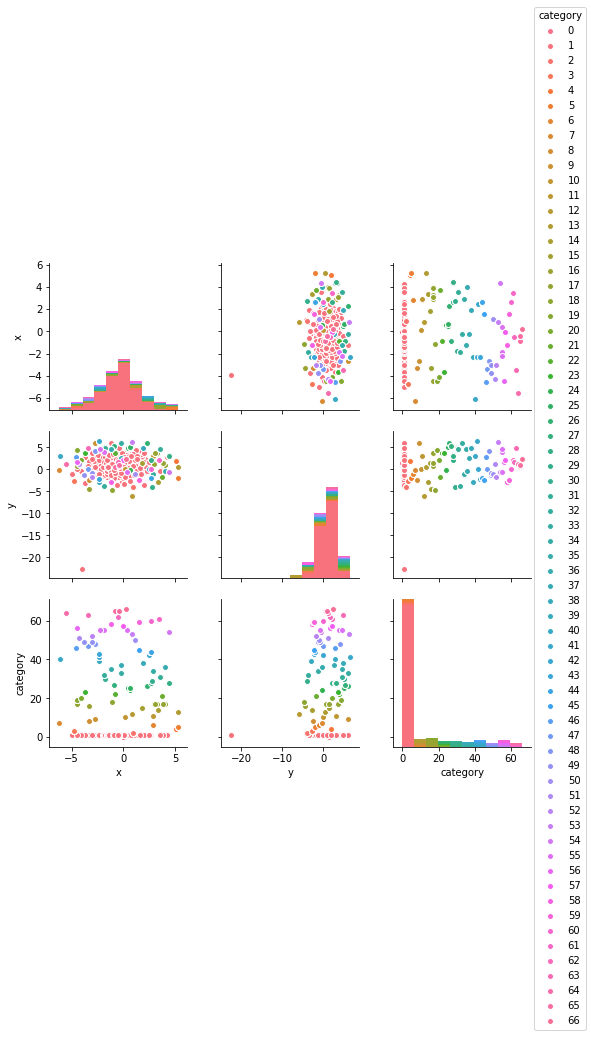

In [3]:
# TF-IDF
texts = [tuple(r) for r in df[['device_name', 'article_content', 'labels_factor']].values]
atxt.run_tfidf(texts, rand_score=True, num_clusters=67)

In [20]:
i = 0
for i, r in enumerate(reviews.items()):
    print(r[1][0][0].strip())
    print(r[1][1])
    if i>200:
        break
    i += 1

1-Ring Moon


If you think smart home tech is creepy, the Moon will be a great device to prove your point. It's a floating eyeball-shaped security cam that can rotate to follow your movements. If you think smart home tech is exciting and inventive, well, the Moon might help you prove that point as well.

According to its description, the Moon is a levitating smart home camera that doubles as a smart home hub from Delaware-based startup 1-Ring. Because the base charges the cam wirelessly while it floats, it can supposedly levitate in perpetuity. From the app, you can rotate the cam to look around the room. It also has motion sensing and microphones on either side of the lens, so it knows what direction a sound is coming from, and can turn silently (since it floats) to track the noise.

The company's Indiegogo campaign (currently more than 200 percent funded) says you can customize what the camera does when it senses something -- you can receive a notification, record a video clip or sna